In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 5
M = 5
G = nx.generators.lattice.grid_2d_graph(N,M)
method = 1

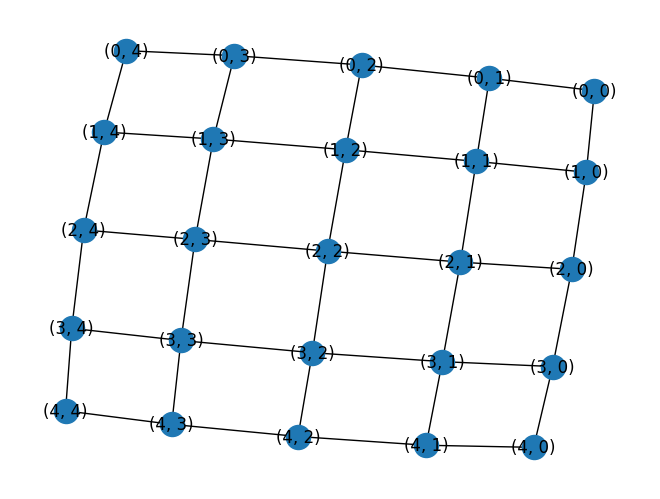

In [3]:
nx.draw(G, with_labels=True)

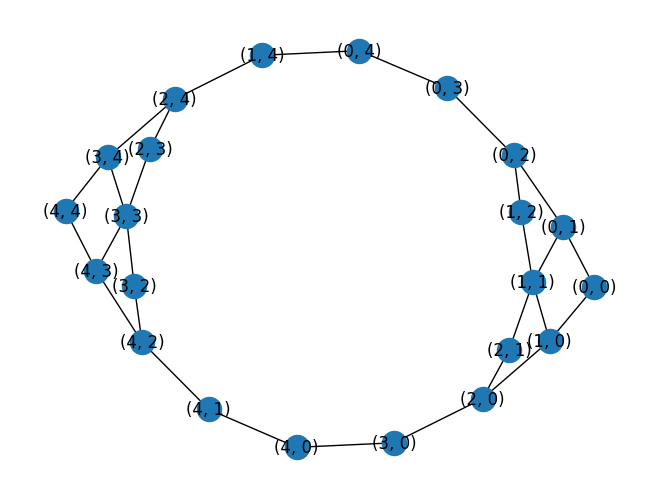

In [162]:
G.remove_node((1, 3))
G.remove_node((3, 1))
G.remove_node((2, 2))
nx.draw(G, with_labels=True)

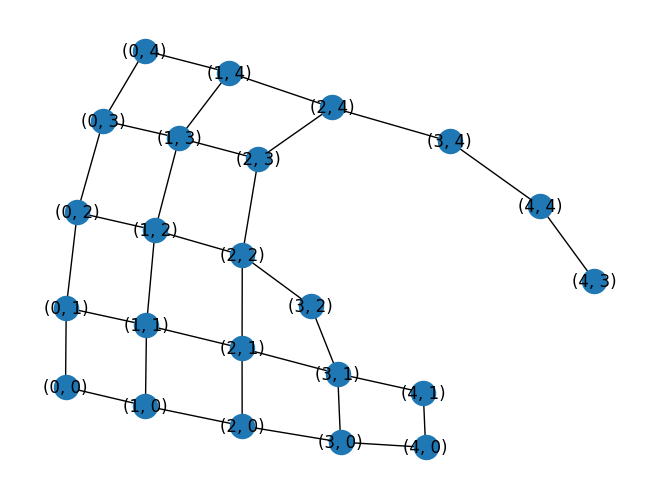

In [24]:
G.remove_node((4, 2))
G.remove_node((3, 3))
nx.draw(G, with_labels=True)

In [4]:
adj_matrix = nx.adjacency_matrix(G).toarray()

In [5]:
edge_indices = {}

In [6]:
nodes_list = list(G.nodes.keys())
for edge_idx, edge in enumerate(G.edges()):
    from_node, to_node = edge
    from_node_idx = nodes_list.index(from_node)
    to_node_idx = nodes_list.index(to_node)
    edge_indices[(from_node_idx, to_node_idx)] = edge_idx * 2
    edge_indices[(to_node_idx, from_node_idx)] = edge_idx * 2 + 1

In [7]:
def calc_action_between_cur_and_next_node(curr_node, next_node):
    curr_x, curr_y = list(G.nodes.keys())[curr_node]
    next_x, next_y = list(G.nodes.keys())[next_node]
    # curr_x = curr_node % N
    # curr_y = curr_node // N
    origin_neighbors = [(curr_x + 1, curr_y), (curr_x - 1, curr_y), (curr_x, curr_y - 1), (curr_x, curr_y + 1)]
    # next_x = next_node % N
    # next_y = next_node // N
    action = origin_neighbors.index((next_x, next_y))
    return action

In [8]:
def do_graph_random_walks(adj_matrix, edge_indices, num_walks, walk_length, method=0):
    num_nodes = adj_matrix.shape[0]
    nodes = np.arange(num_nodes)
    trajectories = []
    for i in range(num_walks):
        trajectory = []
        curr_node = np.random.choice(nodes).item()
        for j in range(walk_length):
            next_node = np.random.choice(np.where(adj_matrix[curr_node] == 1)[0]).item()
            if method == 0: # state-dependent action
                trajectory.append((curr_node, edge_indices[(curr_node, next_node)], next_node))
            else:  # state-independent action (4 action)
                trajectory.append((curr_node, calc_action_between_cur_and_next_node(curr_node, next_node), next_node))
            curr_node = next_node
        trajectories.append(trajectory)
    return np.array(trajectories)

In [9]:
num_walks = 200
walk_length = 32
trajectories = do_graph_random_walks(adj_matrix, edge_indices, num_walks, walk_length, method)

In [10]:
trajectories[0]

array([[10,  3, 11],
       [11,  3, 12],
       [12,  1,  7],
       [ 7,  3,  8],
       [ 8,  0, 13],
       [13,  0, 18],
       [18,  3, 19],
       [19,  1, 14],
       [14,  0, 19],
       [19,  1, 14],
       [14,  0, 19],
       [19,  1, 14],
       [14,  1,  9],
       [ 9,  0, 14],
       [14,  2, 13],
       [13,  3, 14],
       [14,  1,  9],
       [ 9,  1,  4],
       [ 4,  2,  3],
       [ 3,  0,  8],
       [ 8,  1,  3],
       [ 3,  2,  2],
       [ 2,  0,  7],
       [ 7,  3,  8],
       [ 8,  3,  9],
       [ 9,  2,  8],
       [ 8,  0, 13],
       [13,  0, 18],
       [18,  3, 19],
       [19,  2, 18],
       [18,  3, 19],
       [19,  1, 14]])

In [12]:
n_obs = adj_matrix.shape[0]
# n_obs = 2
n_act = len(edge_indices)
emb_dim = 4000
Q_init_stddev = 0.1
V_init_stddev = 0.01
W_init_stddev = 0.01
eta_q = 0.1
eta_v = 0.01
eta_w = 0.01
num_epochs = 10
n_obs, n_act

(25, 80)

In [13]:
np.random.seed(0)
Q = np.random.normal(size=(emb_dim, n_obs)) * Q_init_stddev
V = np.random.normal(size=(emb_dim, n_act)) * V_init_stddev
W = np.random.normal(size=(n_act, emb_dim)) * W_init_stddev
num_trajectories = trajectories.shape[0]
mses1 = []

In [15]:
# for epoch in range(num_epochs):
#     print(f"epoch {epoch}")
#     for traj_idx in range(num_trajectories):
#         nodes = trajectories[traj_idx, :, 0]
#         edges = trajectories[traj_idx, :, 1]
#         next_nodes = trajectories[traj_idx, :, 2]

#         s_curr_DxL = Q[:, nodes]
#         s_next_DxL = Q[:, next_nodes]

#         s_diff_DxL = s_next_DxL - s_curr_DxL
#         pred_err_DxL = s_diff_DxL - V[:, edges]

#         V[:, edges] += eta_v * pred_err_DxL
#         Q[:, next_nodes] += - eta_q * pred_err_DxL
#         W[edges, :] += eta_w * s_diff_DxL.T
#         mses1.append((pred_err_DxL ** 2).mean())
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    for traj_idx in range(num_trajectories):
        nodes = trajectories[traj_idx, :, 0]
        edges = trajectories[traj_idx, :, 1]
        next_nodes = trajectories[traj_idx, :, 2]
        
        cur_obs = np.zeros((Q.shape[1], len(nodes)))
        for idx, node in enumerate(nodes):
            cur_obs[node, idx] = 1
        next_obs = np.zeros((Q.shape[1], len(next_nodes)))
        for idx, node in enumerate(next_nodes):
            next_obs[node, idx] = 1
        # cur_obs = np.array([(x, y) for x, y in zip(nodes // 5, nodes % 5)]).T
        # next_obs = np.array([(x, y) for x, y in zip(next_nodes // 5, next_nodes % 5)]).T
        actions = np.zeros((V.shape[1], len(edges)))
        for idx, edge in enumerate(edges):
            actions[edge, idx] = 1

        s_curr_DxL = Q@cur_obs
        s_next_DxL = Q@next_obs

        s_diff_DxL = s_next_DxL - s_curr_DxL
        pred_err_DxL = s_diff_DxL - V@actions

        V += eta_v * pred_err_DxL@actions.T
        Q += eta_q * pred_err_DxL@(- next_obs).T
        W += eta_w * actions@s_diff_DxL.T
        
        V /= np.linalg.norm(V, axis=0)
        
        mses1.append((pred_err_DxL ** 2).mean())

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


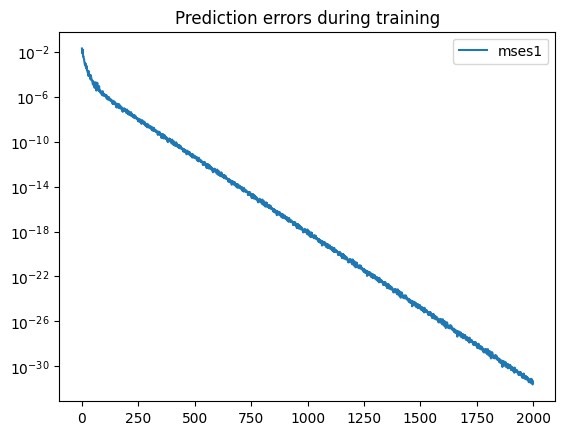

In [16]:
fig, ax = plt.subplots()
ax.plot(mses1, label='mses1')
# ax.plot(mses2, label='mses2')
ax.set_title('Prediction errors during training')
ax.set_yscale('log')
plt.legend()
plt.show()
plt.close(fig)

In [19]:
def CML_planner(start, goal, obs_size, method=0):
    a_record = []
    o_record = []
    loc = int(start)
    for i in range(obs_size):
        o_record.append(loc)
        if loc==goal:
            return i, o_record
        cur_obs = np.zeros((Q.shape[1]))
        cur_obs[loc] = 1
        goal_obs = np.zeros((Q.shape[1]))
        goal_obs[goal] = 1
        # cur_obs = np.array([loc //5, loc %5])
        # goal_obs = np.array([goal //5, goal %5])
        delta = Q@goal_obs - Q@cur_obs  # TODO: start and goal are one-hot vector
        avail_nodes = np.where(adj_matrix[loc] != 0)[0]  # int64
        if method == 0:
            avail_actions = [edge_indices[(loc, int(next_node))] for next_node in avail_nodes]
        else:
            # curr_x = loc % N
            # curr_y = loc // N
            curr_x, curr_y = list(G.nodes.keys())[loc]
            origin_neighbors = [(curr_x + 1, curr_y), (curr_x - 1, curr_y), (curr_x, curr_y - 1), (curr_x, curr_y + 1)]
            # avail_actions = [origin_neighbors.index((next_node%N, next_node//N)) for next_node in avail_nodes]
            avail_actions = [origin_neighbors.index(list(G.nodes.keys())[next_node]) for next_node in avail_nodes]
        utility = delta.T@V[:, avail_actions]
        eligibility = utility / adj_matrix[loc][avail_nodes]
        dtype = [('id', int), ('value', float)]
        values = [(idx, value) for idx, value in enumerate(eligibility)]
        a = np.array(values, dtype=dtype)
        sorted_arr = np.sort(a, order='value')
        sorted_arr = sorted_arr[::-1]  # reverse
        for best_id, _ in sorted_arr:
            loc = int(avail_nodes[best_id])
            # break
            if loc not in o_record:
                break
        # best_id = np.argmax(eligibility)
        # best_action = avail_actions[best_id]
        # loc = int(avail_nodes[best_id])
        # a_record.append(best_action)
    return i, o_record

In [21]:
cml_distance = []
dijkstra_distance = []
graph = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph())
start_id = list(G.nodes.keys()).index((0, 0))
goal_id = list(G.nodes.keys()).index((4, 4))
steps, o_record = CML_planner(start_id, goal_id, n_obs, method)
dijkstra_path = nx.shortest_path(graph, source=start_id, target=goal_id, weight='weight')
print(o_record, dijkstra_path)
dijkstra_steps = len(dijkstra_path) - 1
cml_distance.append(steps)
dijkstra_distance.append(dijkstra_steps)
# cml_distance, dijkstra_distance
np.mean(cml_distance), np.mean(dijkstra_distance)

[0, 1, 6, 7, 12, 13, 18, 23, 24] [0, 1, 2, 3, 4, 9, 14, 19, 24]


(np.float64(8.0), np.float64(8.0))

In [22]:
N_goal = 200
cml_distance = []
dijkstra_distance = []
graph = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph())
for _ in range(N_goal):
    start_id = np.random.randint(low=0, high=adj_matrix.shape[0])
    goal_id = np.random.randint(low=0, high=adj_matrix.shape[0])
    steps, o_record = CML_planner(start_id, goal_id, n_obs, method)
    dijkstra_path = nx.shortest_path(graph, source=start_id, target=goal_id, weight='weight')
    print(o_record, dijkstra_path)
    dijkstra_steps = len(dijkstra_path) - 1
    cml_distance.append(steps)
    dijkstra_distance.append(dijkstra_steps)
# cml_distance, dijkstra_distance
np.mean(cml_distance), np.mean(dijkstra_distance)

[5, 10, 15, 16, 21] [5, 6, 11, 16, 21]
[7, 12, 11, 16, 15, 20] [7, 6, 5, 10, 15, 20]
[23, 18, 13, 8, 7] [23, 18, 13, 8, 7]
[0, 1, 6, 7, 12, 13, 18, 23, 24] [0, 1, 2, 3, 4, 9, 14, 19, 24]
[2, 1, 6, 5, 10] [2, 1, 0, 5, 10]
[4, 3, 2, 1, 0] [4, 3, 2, 1, 0]
[4, 3, 8] [4, 3, 8]
[17, 18] [17, 18]
[20, 15] [20, 15]
[15] [15]
[4, 9, 8, 13, 12, 17] [4, 3, 2, 7, 12, 17]
[19, 14, 9, 4] [19, 14, 9, 4]
[11, 12, 13, 8] [11, 6, 7, 8]
[18, 13, 8] [18, 13, 8]
[4, 3, 2, 1] [4, 3, 2, 1]
[17, 16, 15, 20] [17, 16, 15, 20]
[11, 12, 13, 8, 9, 4] [11, 6, 1, 2, 3, 4]
[17, 18, 23, 24] [17, 18, 19, 24]
[17, 16, 15] [17, 16, 15]
[7, 2] [7, 2]
[1, 6, 7, 12, 13, 18, 23, 24] [1, 2, 3, 4, 9, 14, 19, 24]
[20, 21, 22, 23, 18, 19, 14] [20, 15, 10, 11, 12, 13, 14]
[14, 13, 12, 17, 22, 21] [14, 13, 12, 11, 16, 21]
[18, 17, 12, 11, 6, 5, 0] [18, 13, 8, 3, 2, 1, 0]
[17, 12, 11, 6] [17, 12, 7, 6]
[4, 3, 8] [4, 3, 8]
[13, 8, 3] [13, 8, 3]
[24, 23, 22, 17, 16, 11] [24, 19, 14, 13, 12, 11]
[12, 13, 8] [12, 7, 8]
[16, 15, 10] [16

(np.float64(3.345), np.float64(3.345))

In [ ]:
weighted_matrix = adj_matrix
weighted_matrix[list(G.nodes.keys()).index((1, 3)), list(G.nodes.keys()).index((0, 3))] = 1000
weighted_matrix[list(G.nodes.keys()).index((1, 3)), list(G.nodes.keys()).index((1, 2))] = 1000
weighted_matrix[list(G.nodes.keys()).index((2, 2)), list(G.nodes.keys()).index((1, 2))] = 1000
weighted_matrix[list(G.nodes.keys()).index((2, 2)), list(G.nodes.keys()).index((2, 1))] = 1000
weighted_matrix[list(G.nodes.keys()).index((3, 1)), list(G.nodes.keys()).index((2, 1))] = 1000
weighted_matrix[list(G.nodes.keys()).index((3, 1)), list(G.nodes.keys()).index((3, 0))] = 1000
weighted_matrix = (weighted_matrix + weighted_matrix.T)/2

In [94]:
def path_length(path):
    return np.sum([graph.edges[i, j]['weight'] for i,j in zip(path[:-1], path[1:])])

In [121]:
N_goal = 200
cml_distance = []
dijkstra_distance = []
cml_cost = []
dijkstra_cost = []
graph = nx.from_numpy_array(weighted_matrix, create_using=nx.DiGraph())
for _ in range(N_goal):
    start_id = np.random.randint(0, n_obs)
    goal_id = np.random.randint(0, n_obs)
    steps, o_record = CML_planner(start_id, goal_id, n_obs, method)
    dijkstra_path = nx.shortest_path(graph, source=start_id, target=goal_id, weight='weight')
    # print(o_record, dijkstra_path)
    dijkstra_steps = len(dijkstra_path) - 1
    cml_distance.append(steps)
    cml_cost.append(path_length(o_record))
    dijkstra_distance.append(dijkstra_steps)
    dijkstra_cost.append(path_length(dijkstra_path))
# cml_distance, dijkstra_distance
# np.mean(cml_distance), np.mean(dijkstra_distance)
np.mean(cml_cost), np.mean(dijkstra_cost)

(np.float64(233.12), np.float64(4.08))

In [ ]:
weights = (np.arange(10)+1)*100
cml_costs = []
dij_costs = []
for w in weights:
    weighted_matrix = adj_matrix
    weighted_matrix[list(G.nodes.keys()).index((1, 3)), list(G.nodes.keys()).index((0, 3))] = w
    weighted_matrix[list(G.nodes.keys()).index((1, 3)), list(G.nodes.keys()).index((1, 2))] = w
    weighted_matrix[list(G.nodes.keys()).index((2, 2)), list(G.nodes.keys()).index((1, 2))] = w
    weighted_matrix[list(G.nodes.keys()).index((2, 2)), list(G.nodes.keys()).index((2, 1))] = w
    weighted_matrix[list(G.nodes.keys()).index((3, 1)), list(G.nodes.keys()).index((2, 1))] = w
    weighted_matrix[list(G.nodes.keys()).index((3, 1)), list(G.nodes.keys()).index((3, 0))] = w
    weighted_matrix = (weighted_matrix + weighted_matrix.T)/2
    N_goal = 200
    cml_distance = []
    dijkstra_distance = []
    cml_cost = []
    dijkstra_cost = []
    graph = nx.from_numpy_array(weighted_matrix, create_using=nx.DiGraph())
    for _ in range(N_goal):
        start_id = np.random.randint(0, n_obs)
        goal_id = np.random.randint(0, n_obs)
        steps, o_record = CML_planner(start_id, goal_id, n_obs, method)
        dijkstra_path = nx.shortest_path(graph, source=start_id, target=goal_id, weight='weight')
        # print(o_record, dijkstra_path)
        dijkstra_steps = len(dijkstra_path) - 1
        cml_distance.append(steps)
        cml_cost.append(path_length(o_record))
        dijkstra_distance.append(dijkstra_steps)
        dijkstra_cost.append(path_length(dijkstra_path))
    # cml_distance, dijkstra_distance
    # np.mean(cml_distance), np.mean(dijkstra_distance)
    cml_costs.append(np.mean(cml_cost))
    dij_costs.append(np.mean(dijkstra_cost))

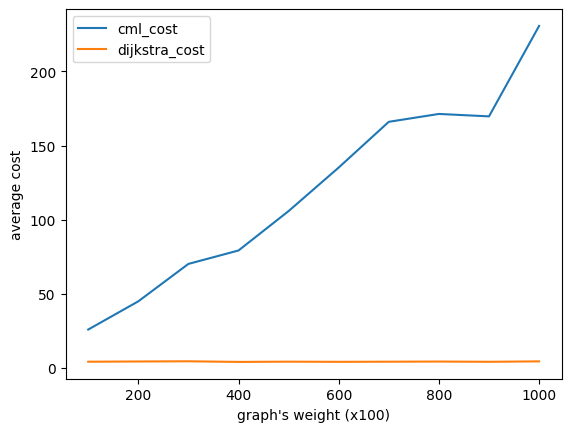

In [130]:
plt.plot(weights, cml_costs, label='cml_cost')
plt.plot(weights, dij_costs, label='dijkstra_cost')
plt.legend()
plt.ylabel('average cost')
plt.xlabel('''graph's weight (x100)''')
plt.show()

In [131]:
cml_costs, dij_costs

([np.float64(25.7925),
  np.float64(44.8425),
  np.float64(70.1075),
  np.float64(79.16),
  np.float64(105.77),
  np.float64(135.15),
  np.float64(166.0125),
  np.float64(171.32),
  np.float64(169.68),
  np.float64(230.7275)],
 [np.float64(4.09),
  np.float64(4.24),
  np.float64(4.38),
  np.float64(3.95),
  np.float64(4.125),
  np.float64(4.01),
  np.float64(4.105),
  np.float64(4.2),
  np.float64(4.035),
  np.float64(4.325)])